# Welcome to Colab!

In [25]:
# =========================
#  Import Libraries
# =========================
import pandas as pd          # Data manipulation and analysis
import numpy as np           # Numerical computations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns        # Statistical data visualization
from sklearn.model_selection import train_test_split  # Split data into train/test sets
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert text to TF-IDF features
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes classifier for text data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # Model evaluation metrics
from scipy.sparse import hstack  # Combine sparse text features with numerical features

In [26]:
# =========================
#  Load Data
# =========================

import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("gorororororo23/european-restaurant-reviews")
print("Path to dataset files:", path)

# List files inside the downloaded folder
files = os.listdir(path)
print("Files found:", files)

# Find the CSV file automatically
csv_files = [f for f in files if f.endswith(".csv")]

# Read the first CSV file
csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)

# Show first rows
print(df.head())
print("-"*80)
print("data columns are : ",df.columns)
print("-"*80)
print("the shape of the data is : ",df.shape)
print("-"*80)
print("check if there any null value: ",df.isnull().sum())

Using Colab cache for faster access to the 'european-restaurant-reviews' dataset.
Path to dataset files: /kaggle/input/european-restaurant-reviews
Files found: ['European Restaurant Reviews.csv']
  Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review Title Review Date  \
0                               Rude manager  May 2024 •   
1                       A big disappointment  Feb 2024 •   
2               Pretty Place with Bland Food  Nov 2023 •   
3   Great service and wine but inedible food  Mar 2023 •   
4  Avoid- Worst meal in Rome - possibly ever  Nov 2022 •   

                                              Review  
0  The manager became agressive when I said the c...  
1  I ordered a beef fillet ask t

Naive Bayes Test Accuracy: 0.8538205980066446
              precision    recall  f1-score   support

    Negative       1.00      0.10      0.19        49
    Positive       0.85      1.00      0.92       252

    accuracy                           0.85       301
   macro avg       0.93      0.55      0.55       301
weighted avg       0.88      0.85      0.80       301



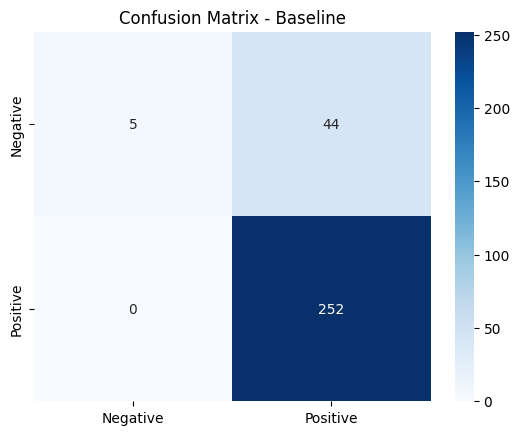

In [27]:
# =================================================
# 1) Data Cleaning / Preprocessing
# =================================================
df = df.dropna(subset=['Review', 'Sentiment'])

text_col = "Review"
target_col = "Sentiment"
df

# =================================================
# 2) Feature Engineering (Numeric Features)
# =================================================
df['review_length'] = df['Review'].apply(len)
df['word_count'] = df['Review'].apply(lambda x: len(x.split()))
df['exclamation_count'] = df['Review'].apply(lambda x: x.count('!'))


# =================================================
# 3) Train-Test Split
# =================================================
X_text = df[text_col]
X_num = df[['review_length','word_count','exclamation_count']].values
y = df[target_col]

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)


# =================================================
# 4) Text Vectorization (TF-IDF)
# =================================================
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Combine TF-IDF with numeric features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])


# =================================================
# 5) Model Training (Naive Bayes)
# =================================================
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_combined, y_train)


# =================================================
# 6) Model Evaluation
# =================================================
y_pred = nb_model.predict(X_test_combined)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix - Baseline")
plt.show()

This plot visualizes the distribution of positive and negative reviews, highlighting the class imbalance in the dataset.


/tmp/ipython-input-3251023845.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="Sentiment", data=df, order=order, palette=palette)


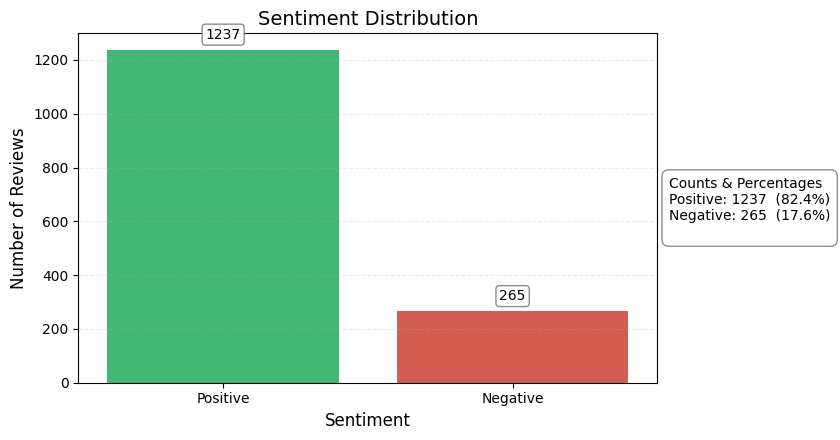

In [34]:
print("This plot visualizes the distribution of positive and negative reviews, highlighting the class imbalance in the dataset.")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8.5, 4.5))  # مساحة أكبر

# Order + custom colors for classes
order = df["Sentiment"].value_counts().index
palette = {"Positive": "#2ecc71", "Negative": "#e74c3c"}  # أخضر/أحمر

ax = sns.countplot(x="Sentiment", data=df, order=order, palette=palette)

# Add counts on top of bars (inside small boxes)
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom", fontsize=10,
        xytext=(0, 6), textcoords="offset points",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9)
    )

# Title and labels
plt.title("Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)

# Light grid
plt.grid(axis="y", linestyle="--", alpha=0.25)

# ---- Side box with counts + percentages ----
counts = df["Sentiment"].value_counts()
total = len(df)

info_text = "Counts & Percentages\n"
for cls in order:
    c = counts[cls]
    pct = (c / total) * 100
    info_text += f"{cls}: {c}  ({pct:.1f}%)\n"

# Make space on the right for the box
plt.subplots_adjust(right=0.78)

# Add the side box
plt.gca().text(
    1.02, 0.5, info_text,
    transform=plt.gca().transAxes,
    fontsize=10, va="center",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9)
)

plt.tight_layout()
plt.show()

This chart shows the top 5 countries by number of reviews.


/tmp/ipython-input-3962385080.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top.values, y=top.index, palette="mako")  # clean palette


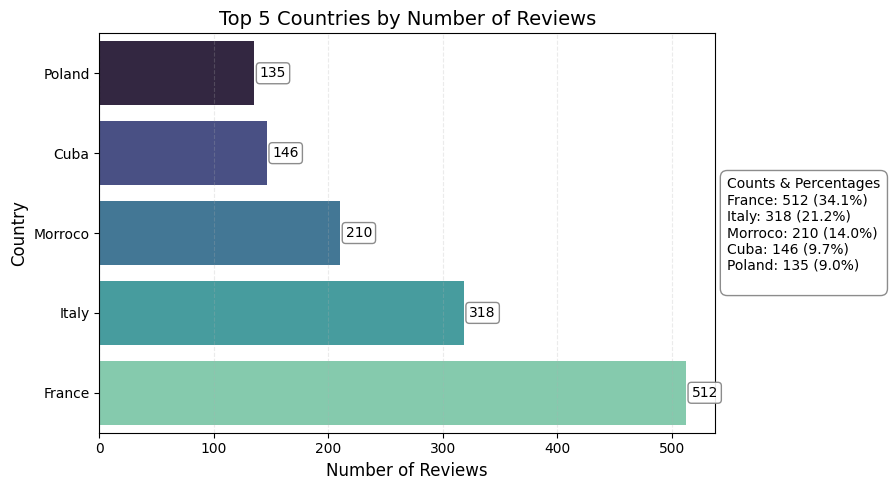

In [43]:
print("This chart shows the top 5 countries by number of reviews.")

import matplotlib.pyplot as plt
import seaborn as sns

top = df["Country"].value_counts().head(5).sort_values()  # sort for nice horizontal order
total = len(df)

plt.figure(figsize=(9, 5))
ax = sns.barplot(x=top.values, y=top.index, palette="mako")  # clean palette

# numbers on bars (boxed)
for i, v in enumerate(top.values):
    ax.text(
        v + (top.values.max() * 0.01), i, f"{v}",
        va="center", fontsize=10,
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=0.9)
    )

plt.title("Top 5 Countries by Number of Reviews", fontsize=14)
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.25)

# side box with percentages
info_text = "Counts & Percentages\n"
for c, v in top.sort_values(ascending=False).items():
    pct = (v / total) * 100
    info_text += f"{c}: {v} ({pct:.1f}%)\n"

plt.subplots_adjust(right=0.78)
plt.gca().text(
    1.02, 0.5, info_text,
    transform=plt.gca().transAxes,
    fontsize=10, va="center",
    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9)
)

plt.tight_layout()
plt.show()

This boxplot compares review lengths between Positive and Negative sentiments.


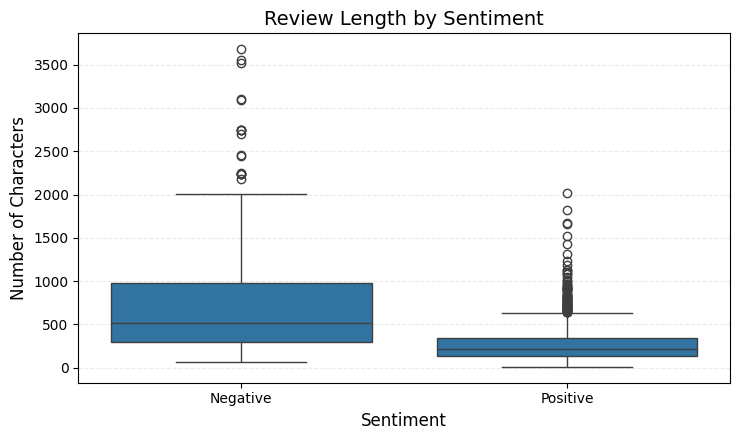

In [48]:
print("This boxplot compares review lengths between Positive and Negative sentiments.")

plt.figure(figsize=(7.5,4.5))
ax = sns.boxplot(x="Sentiment", y="review_length", data=df)

plt.title("Review Length by Sentiment", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Characters", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.25)
plt.tight_layout()
plt.show()


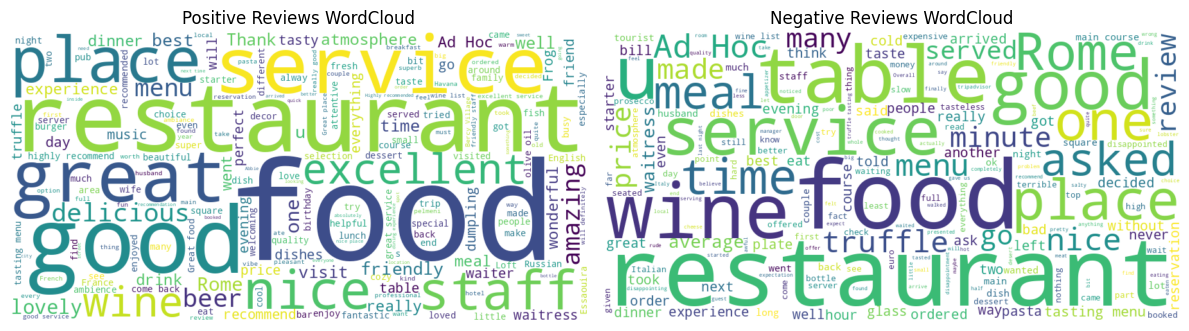

In [50]:
# (Run once if needed)
# !pip -q install wordcloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Make sure Review is string
df["Review"] = df["Review"].astype(str)

# Split text by sentiment
pos_text = " ".join(df[df["Sentiment"] == "Positive"]["Review"])
neg_text = " ".join(df[df["Sentiment"] == "Negative"]["Review"])

# Create wordclouds
wc_pos = WordCloud(
    width=900, height=450,
    background_color="white",
    stopwords=STOPWORDS
).generate(pos_text)

wc_neg = WordCloud(
    width=900, height=450,
    background_color="white",
    stopwords=STOPWORDS
).generate(neg_text)

# Display side by side
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews WordCloud")

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews WordCloud")

plt.tight_layout()
plt.show()

Model **Improvement**

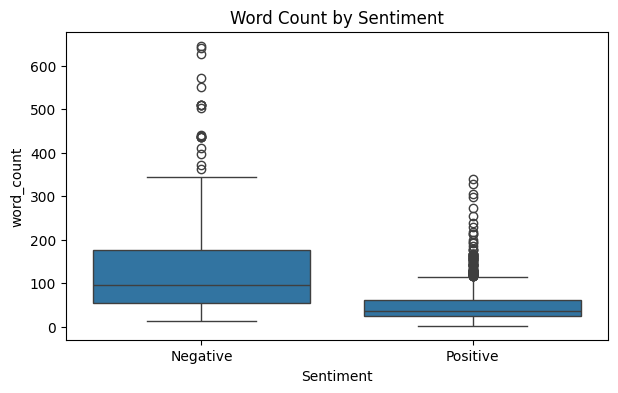

In [52]:
#Positive and negative word counts were computed based on the presence of predefined sentiment words within each review.

# =========================
# Feature Engineering (Enhanced)
# =========================
df['review_length'] = df['Review'].apply(len)  # length of the review
df['word_count'] = df['Review'].apply(lambda x: len(x.split()))  # number of words
df['exclamation_count'] = df['Review'].apply(lambda x: x.count('!'))  # number of '!'
df['question_count'] = df['Review'].apply(lambda x: x.count('?'))  # number of '?'

# Simple positive and negative word lists
positive_words = ['amazing', 'excellent', 'good', 'nice', 'delicious', 'perfect', 'best']
negative_words = ['bad', 'terrible', 'horrible', 'awful', 'disappointing', 'worst']

df['pos_word_count'] = df['Review'].apply(lambda x: sum(word in x.lower() for word in positive_words))  # count of positive words
df['neg_word_count'] = df['Review'].apply(lambda x: sum(word in x.lower() for word in negative_words))  # count of negative words

num_features = ['review_length','word_count','exclamation_count','question_count','pos_word_count','neg_word_count']

#  Print output to see results
print("New feature columns added:", num_features)
print("\n Sample rows (Review + features):")
print(df[['Review'] + num_features].head(5))

print("\n Quick stats for features:")
print(df[num_features].describe())


New feature columns added: ['review_length', 'word_count', 'exclamation_count', 'question_count', 'pos_word_count', 'neg_word_count']

 Sample rows (Review + features):
                                              Review  review_length  \
0  The manager became agressive when I said the c...            146   
1  I ordered a beef fillet ask to be done medium,...            281   
2  This is an attractive venue with welcoming, al...            260   
3  Sadly I  used the high TripAdvisor rating too ...           1513   
4  From the start this meal was bad- especially g...           1351   

   word_count  exclamation_count  question_count  pos_word_count  \
0          28                  0               0               1   
1          58                  0               0               0   
2          40                  0               0               0   
3         279                  0               0               4   
4         243                  0               0               2

In [53]:
## Split the dataset into training and testing sets (text + numeric features)
# =========================
#  Split Dataset
# =========================
X_text = df['Review']  # text feature
X_num = df[num_features].values  # numerical features
y = df['Sentiment']  # target

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42
)

In [54]:
# Convert text reviews into TF-IDF features, then combine with numeric features
# =========================
# TF-IDF Vectorization (Enhanced)
# =========================

# Ensure text is string (safe)
X_train_text = X_train_text.astype(str)
X_test_text  = X_test_text.astype(str)

# TF-IDF settings (enhanced)
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=8000,
    ngram_range=(1, 3),
    min_df=5,
    max_df=0.8
)

# Fit on training text, transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

# Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined  = hstack([X_test_tfidf, X_test_num])

In [55]:
# =========================
#  Train Naive Bayes Model
# =========================

# Train the classifier on the combined TF-IDF + numeric features
nb_model = MultinomialNB(alpha=0.5)  # smoothing parameter
nb_model.fit(X_train_combined, y_train)

MultinomialNB(alpha=0.5)

Improved Naive Bayes Test Accuracy: 0.920265780730897
              precision    recall  f1-score   support

    Negative       0.73      0.82      0.77        49
    Positive       0.96      0.94      0.95       252

    accuracy                           0.92       301
   macro avg       0.85      0.88      0.86       301
weighted avg       0.92      0.92      0.92       301



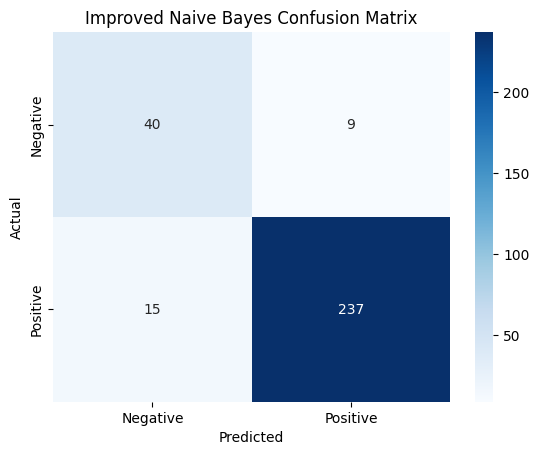

In [56]:
# =========================
#  Evaluation
# =========================
y_pred = nb_model.predict(X_test_combined)

print("Improved Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix (keep class order consistent)
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Improved Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

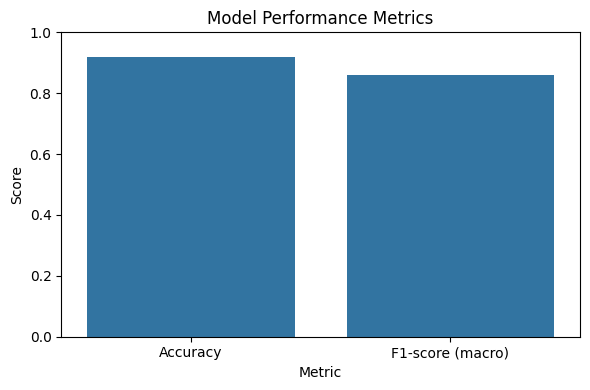

In [62]:
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1-score (macro)"],
    "Score": [
        accuracy_score(y_test, y_pred),
        classification_report(y_test, y_pred, output_dict=True)["macro avg"]["f1-score"]
    ]
})

plt.figure(figsize=(6,4))
sns.barplot(x="Metric", y="Score", data=metrics_df)
plt.ylim(0,1)
plt.title("Model Performance Metrics")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 576 candidates, totalling 2880 fits

===== BEST PARAMS =====
{'alpha': 0.1, 'fit_prior': False, 'max_df': 0.8, 'max_features': 8000, 'min_df': 2, 'ngram_range': (1, 3), 'sublinear_tf': False}
Best CV F1-macro: 0.9117063443663312

===== TEST RESULTS (GridSearch Best) =====
Accuracy: 0.9534883720930233
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85        49
    Positive       0.97      0.98      0.97       252

    accuracy                           0.95       301
   macro avg       0.92      0.91      0.91       301
weighted avg       0.95      0.95      0.95       301



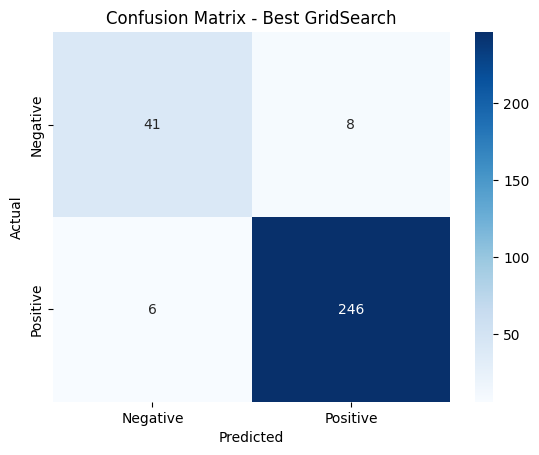

In [ ]:
# =========================
#  Prepare data for GridSearch (DataFrame format)
# =========================
# Create a DataFrame that contains the text column + numeric feature columns
X_train_df = pd.concat(
    [X_train_text.reset_index(drop=True),
     pd.DataFrame(X_train_num, columns=num_features)],
    axis=1
)
X_train_df.columns = ["Review"] + num_features

X_test_df = pd.concat(
    [X_test_text.reset_index(drop=True),
     pd.DataFrame(X_test_num, columns=num_features)],
    axis=1
)
X_test_df.columns = ["Review"] + num_features


# =========================
#  Custom model wrapper (TF-IDF + numeric features + Naive Bayes)
# =========================
# This custom estimator allows GridSearchCV to tune TF-IDF and NB parameters together
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV

class TfidfHstackNB(BaseEstimator, ClassifierMixin):
    def __init__(self, ngram_range=(1,3), max_features=8000, min_df=5, max_df=0.8,
                 sublinear_tf=False, alpha=0.5, fit_prior=True):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.min_df = min_df
        self.max_df = max_df
        self.sublinear_tf = sublinear_tf
        self.alpha = alpha
        self.fit_prior = fit_prior

    def fit(self, X, y):
        # Split input into text and numeric features
        X_text = X["Review"].astype(str)
        X_num  = X[num_features].values

        # Convert text to TF-IDF features
        self.tfidf_ = TfidfVectorizer(
            stop_words="english",
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            min_df=self.min_df,
            max_df=self.max_df,
            sublinear_tf=self.sublinear_tf
        )

        # Combine TF-IDF with numeric features
        X_tfidf = self.tfidf_.fit_transform(X_text)
        X_combined = hstack([X_tfidf, X_num])

        # Train Naive Bayes classifier
        self.nb_ = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior)
        self.nb_.fit(X_combined, y)
        return self

    def predict(self, X):
        # Transform input using the fitted TF-IDF, then predict with NB
        X_text = X["Review"].astype(str)
        X_num  = X[num_features].values

        X_tfidf = self.tfidf_.transform(X_text)
        X_combined = hstack([X_tfidf, X_num])
        return self.nb_.predict(X_combined)


# =========================
# Define GridSearch parameters
# =========================
# Search over different TF-IDF and Naive Bayes settings
param_grid = {
    "ngram_range": [(1,1), (1,2), (1,3)],
    "max_features": [5000, 8000, 12000],
    "min_df": [2, 5],
    "max_df": [0.8, 0.9],
    "sublinear_tf": [True, False],
    "alpha": [0.1, 0.3, 0.5, 1.0],
    "fit_prior": [True, False],
}


# =========================
#  Run GridSearchCV
# =========================
# Use cross-validation to find the best combination based on F1-macro
grid = GridSearchCV(
    estimator=TfidfHstackNB(),
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_df, y_train)

print("\n===== BEST PARAMS =====")
print(grid.best_params_)
print("Best CV F1-macro:", grid.best_score_)


# =========================
#  Evaluate the best model on the test set
# =========================
best_model = grid.best_estimator_
y_pred_gs = best_model.predict(X_test_df)

print("\n===== TEST RESULTS (GridSearch Best) =====")
print("Accuracy:", accuracy_score(y_test, y_pred_gs))
print(classification_report(y_test, y_pred_gs))

cm = confusion_matrix(y_test, y_pred_gs, labels=best_model.nb_.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.nb_.classes_, yticklabels=best_model.nb_.classes_)
plt.title("Confusion Matrix - Best GridSearch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

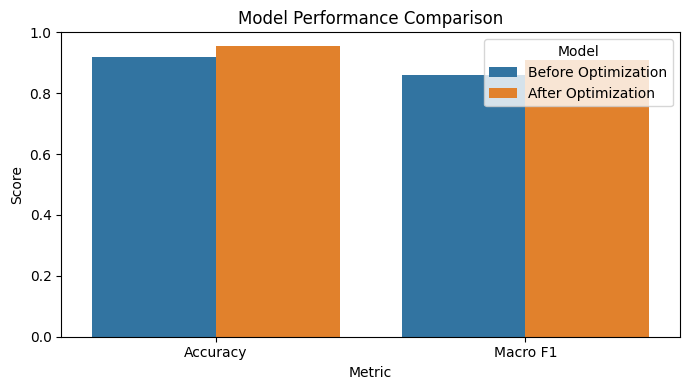

In [65]:
comparison_df = pd.DataFrame({
    "Model": ["Before Optimization", "After Optimization"],
    "Accuracy": [0.9203, 0.9535],
    "Macro F1": [0.86, 0.91]
})

comparison_df_melt = comparison_df.melt(id_vars="Model",
                                        value_vars=["Accuracy", "Macro F1"],
                                        var_name="Metric",
                                        value_name="Score")

plt.figure(figsize=(7,4))
sns.barplot(x="Metric", y="Score", hue="Model", data=comparison_df_melt)
plt.ylim(0,1)
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.show()

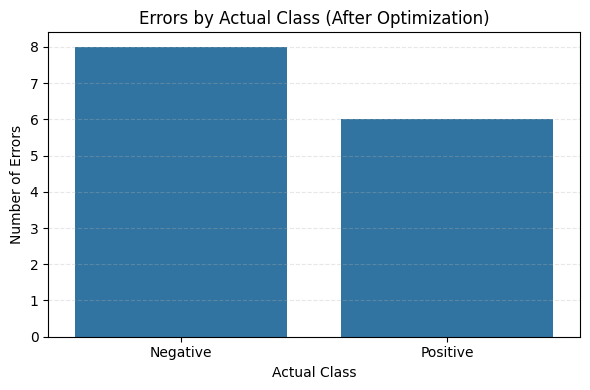

In [66]:
errors = (y_test != y_pred_gs)

err_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_gs,
    "Error": errors
})

plt.figure(figsize=(6,4))
sns.countplot(data=err_df[err_df["Error"] == True], x="Actual")
plt.title("Errors by Actual Class (After Optimization)")
plt.xlabel("Actual Class")
plt.ylabel("Number of Errors")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()